# Training a 3D UNet wih MONAI



# Part 1 - Basic training loop

## Set up environment

In [1]:
!pip -q install "monai-weekly" "torch>=2.1" "tqdm"

In [2]:
import monai, torch, os, tempfile, matplotlib.pyplot as plt
from monai.data import DataLoader, CacheDataset
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

/Users/pwilson/anaconda3/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/pwilson/anaconda3/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <BD0BF3A8-D5AB-3800-B76D-0E8456DB6589> /Users/pwilson/anaconda3/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <25C510F7-7AEE-3D64-80ED-95874DC6BECD> /Users/pwilson/anaconda3/envs/ai/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Download the dataset

In [5]:

from monai.apps import download_and_extract
root_dir = 'data'
resource = 'https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar'
compressed_file = os.path.join(root_dir, "spleen.tar")

if not os.path.exists(root_dir):
    download_and_extract(resource, compressed_file, root_dir)


## Prepare the dataset

In [6]:
from monai.data import Dataset
from glob import glob
images = sorted(glob(os.path.join(root_dir,"Task09_Spleen/imagesTr/*.nii.gz")))
labels = sorted(glob(os.path.join(root_dir,"Task09_Spleen/labelsTr/*.nii.gz")))
train_files = [{"image":img, "label":lbl} for img,lbl in zip(images,labels)]

print(f"Number of files: {len(train_files)}")
print(train_files[0])

Number of files: 41
{'image': 'data/Task09_Spleen/imagesTr/spleen_10.nii.gz', 'label': 'data/Task09_Spleen/labelsTr/spleen_10.nii.gz'}


In [7]:
from monai import transforms as T

def make_transform(n_pixels=64):
    # Steps to transform the file information to model inputs:

    transforms = []

    # step 1: load the data, nii.gz format to tensor
    transforms.append(
        T.LoadImaged(keys=['image', 'label'])
    )

    # step 2: Add an extra "channel" dimension (pytorch/monai convention)
    transforms.append(
        T.EnsureChannelFirstd(keys=['image', 'label'])
    )

    # step 3: Resize the data to a uniform size
    transforms.append(
        T.ResizeD(keys=['image', 'label'], spatial_size=(n_pixels, n_pixels, n_pixels//2), mode=['bilinear', 'nearest'])
    )

    # step 4: rescale the image intenisty between 0 and 1
    transforms.append(T.ScaleIntensityD(keys=['image']))

    transform = T.Compose(transforms)
    return transform


transform = make_transform(256)

pixel mean: 0.14207446575164795
pixel std: 0.11840797960758209
Image shape: torch.Size([1, 256, 256, 128])
Label shape: torch.Size([1, 256, 256, 128])
Label values: tensor([0., 1.])


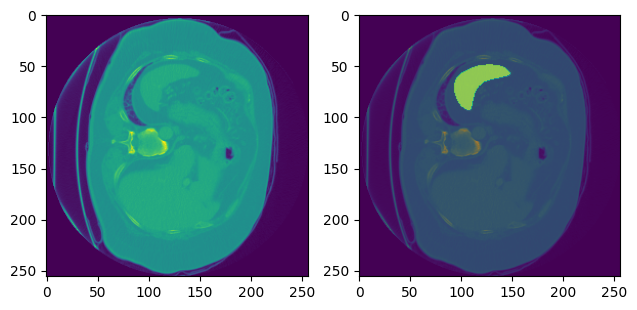

In [8]:
# look at the output
data = transform(train_files[0])
fig, ax = plt.subplots(1, 2)
ax[0].imshow(data['image'][0, ..., 75])
ax[1].imshow(data['image'][0, ..., 75])
ax[1].imshow(data['label'][0, ..., 75], alpha=0.5)
fig.tight_layout()

image = data['image']
label = data['label']
print(f"pixel mean: {image.mean()}")
print(f"pixel std: {image.std()}")
print(f"Image shape: {image.shape}")
print(f"Label shape: {label.shape}")
print(f"Label values: {torch.unique(label)}")

In [9]:
# create dataset and dataloader
train_ds = train_dataset = monai.data.CacheDataset(train_files, transform=make_transform(64), cache_rate=1)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=4, shuffle=True)

batch = next(iter(train_loader))
image = batch['image']
label = batch['label']
print(f'Image shape: {image.shape}')
print(f'Label shape: {label.shape}')


Loading dataset: 100%|██████████| 41/41 [00:18<00:00,  2.26it/s]

Image shape: torch.Size([4, 1, 64, 64, 32])
Label shape: torch.Size([4, 1, 64, 64, 32])


## Prepare And Train the Model

In [10]:
# define a unet using monai

def get_model():
    return UNet(spatial_dims=3, in_channels=1, out_channels=2,
             channels=(16,32,64,128), strides=(2,2,2),
             num_res_units=2)

model = get_model()

n_params = sum(p.numel() for p in model.parameters())
print(f"Model has {n_params} parameters.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # device to run calculations - "cuda" means gpu
print(f"Using device {device}")
model.to(device) # convert model to the correct device
loss_fn = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

Model has 1186765 parameters.
Using device cpu


Epoch 1, avg loss: 0.5380


Epoch 2, avg loss: 0.5113


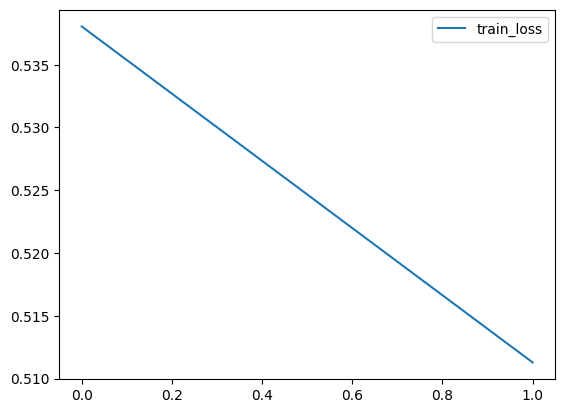

In [13]:
from tqdm import tqdm
from collections import defaultdict


def run_training(model, optimizer, loss_fn, train_dataloader, val_dataloader=None, max_epochs=100):

    history = defaultdict(list)

    for epoch in range(max_epochs):
        model.train()
        epoch_loss = 0
        for batch_data in tqdm(train_dataloader, desc=f"Epoch {epoch}", leave=False):
            inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}, avg loss: {epoch_loss/len(train_dataloader):.4f}")
        history['train_loss'].append(epoch_loss/len(train_dataloader))

        if val_dataloader is not None:
            model.eval()
            epoch_loss = 0
            with torch.no_grad():
                for batch_data in tqdm(val_dataloader, desc=f"Epoch {epoch}", leave=False):
                    inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    epoch_loss += loss.item()
            history['val_loss'].append(epoch_loss/len(val_dataloader))

    return history


history = run_training(model, optimizer, loss_fn, train_loader, max_epochs=2)

key = 'loss'
for name, metrics in history.items():
    if key not in name:
        continue
    plt.plot(metrics, label=name)
plt.legend()


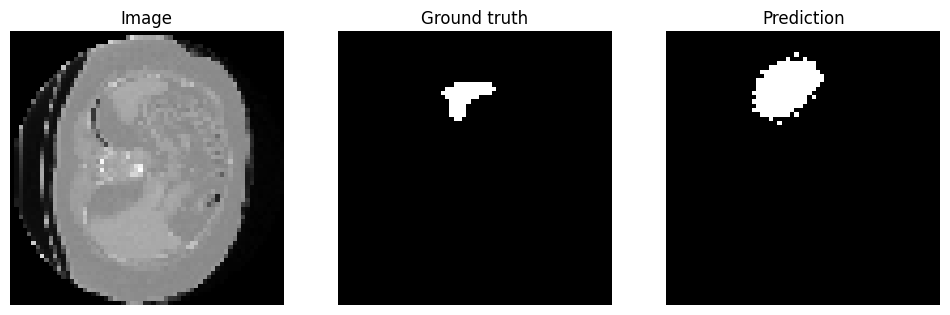

In [14]:
# test inference

model.eval()
with torch.no_grad():
    sample = train_ds[0]
    input_volume = sample["image"].unsqueeze(0).to(device)
    pred = torch.argmax(model(input_volume), dim=1).cpu()[0]

import numpy as np, matplotlib.pyplot as plt
mid_slice = pred.shape[-1]//2
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(input_volume.cpu()[0,0,:, :, mid_slice], cmap='gray'); plt.title('Image'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(sample["label"][0, :, :, mid_slice], cmap='gray'); plt.title('Ground truth'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(pred[:, :, mid_slice], cmap='gray'); plt.title('Prediction'); plt.axis('off')
plt.show()


# Part 2 - Monitoring Model Performance

Objectives:
- Use metrics to measure model performance
- Use cross validation to test for overfitting
- Use techniques to mitigate overfitting

Step 1: implement the dice metric. Hint: use the monai implementation https://docs.monai.io/en/stable/metrics.html#mean-dice and read its documentation. Incorporate it into the training loop defined above to get the new training loop.

In [15]:
from monai.metrics import DiceMetric


def run_training_with_dice(model, optimizer, loss_fn, train_dataloader, val_dataloader=None, max_epochs=100):
    """
    Implements a training loop that includes the dice metric.
    """

    history = defaultdict(list)
    dice_metric = DiceMetric(include_background=False) # Solution: use monai DiceMetric

    for epoch in range(max_epochs):
        
        model.train()
        epoch_loss = 0
        dice_metric.reset()

        for batch_data in tqdm(train_dataloader, desc=f"Epoch {epoch}", leave=False):
            inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            dice = dice_metric(outputs.argmax(1), labels[:, 0]) # update the metric
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}, avg loss: {epoch_loss/len(train_dataloader):.4f}")
        history['train_loss'].append(epoch_loss/len(train_dataloader))
        history['train_dice'].append(dice_metric.aggregate().item()) # compute the average value

        if val_dataloader is not None:
            model.eval()
            epoch_loss = 0
            dice_metric.reset()
            
            with torch.no_grad():
                for batch_data in tqdm(val_dataloader, desc=f"Epoch {epoch}", leave=False):
                    inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    dice = dice_metric(outputs.argmax(1), labels[:, 0])
                    epoch_loss += loss.item()

            history['val_loss'].append(epoch_loss/len(val_dataloader))
            history['val_dice'].append(dice_metric.aggregate().item())

    return history
    


Model has 1186765 parameters.
Using device cpu


Epoch 1, avg loss: 0.6087


Epoch 2, avg loss: 0.5743


Epoch 3, avg loss: 0.5552


Epoch 4, avg loss: 0.5375


Epoch 5, avg loss: 0.5222


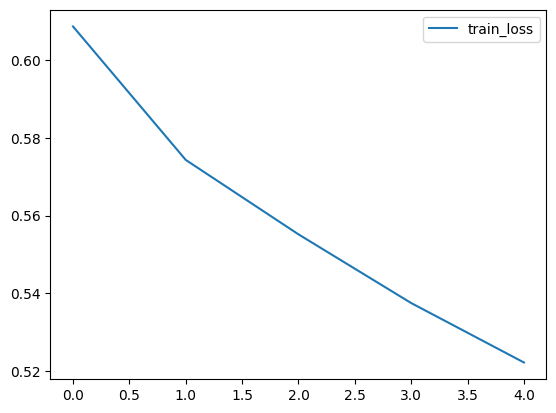

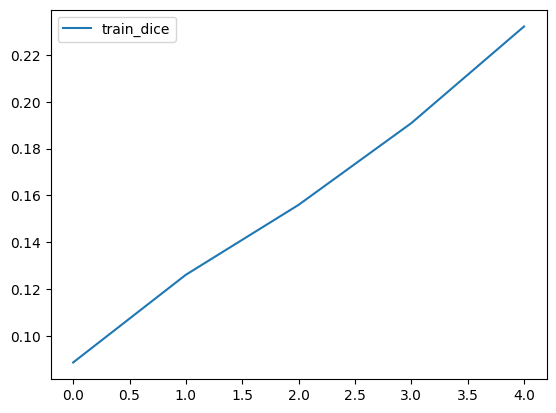

In [17]:
model = get_model()

n_params = sum(p.numel() for p in model.parameters())
print(f"Model has {n_params} parameters.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # device to run calculations - "cuda" means gpu
print(f"Using device {device}")
model.to(device) # convert model to the correct device
loss_fn = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

history = run_training_with_dice(model, optimizer, loss_fn, train_loader, max_epochs=5)

key = 'loss'
for name, metrics in history.items():
    if key not in name:
        continue
    plt.plot(metrics, label=name)
plt.legend()

plt.figure()
key = 'dice'
for name, metrics in history.items():
    if key not in name:
        continue
    plt.plot(metrics, label=name)
plt.legend()

Step 2. Because we don't have a validation set yet, we don't know how well the model will generalize to new data. It could be overfitting to the training set! Create a validation set and run the training loop again. Compare the validation metrics to the training metrics. If the training loss is lower than the validation loss or the training dice is higher than the validation dice, this indicates overfitting.

In [19]:
# Helpful demo: sklearn train_test_split function
# sklearn train_test_split demo
import sklearn.model_selection
new_train_files, val_files = sklearn.model_selection.train_test_split(train_files)

print(len(new_train_files))
print(new_train_files)
print(len(val_files))
print(val_files)

30
[{'image': 'data/Task09_Spleen/imagesTr/spleen_3.nii.gz', 'label': 'data/Task09_Spleen/labelsTr/spleen_3.nii.gz'}, {'image': 'data/Task09_Spleen/imagesTr/spleen_17.nii.gz', 'label': 'data/Task09_Spleen/labelsTr/spleen_17.nii.gz'}, {'image': 'data/Task09_Spleen/imagesTr/spleen_19.nii.gz', 'label': 'data/Task09_Spleen/labelsTr/spleen_19.nii.gz'}, {'image': 'data/Task09_Spleen/imagesTr/spleen_33.nii.gz', 'label': 'data/Task09_Spleen/labelsTr/spleen_33.nii.gz'}, {'image': 'data/Task09_Spleen/imagesTr/spleen_46.nii.gz', 'label': 'data/Task09_Spleen/labelsTr/spleen_46.nii.gz'}, {'image': 'data/Task09_Spleen/imagesTr/spleen_40.nii.gz', 'label': 'data/Task09_Spleen/labelsTr/spleen_40.nii.gz'}, {'image': 'data/Task09_Spleen/imagesTr/spleen_45.nii.gz', 'label': 'data/Task09_Spleen/labelsTr/spleen_45.nii.gz'}, {'image': 'data/Task09_Spleen/imagesTr/spleen_63.nii.gz', 'label': 'data/Task09_Spleen/labelsTr/spleen_63.nii.gz'}, {'image': 'data/Task09_Spleen/imagesTr/spleen_9.nii.gz', 'label': 'dat

In [128]:
# TODO - implement the validation loader. Hint: use the sklearn train_test_split function, then follow the "Prepare dataset"
# recipe with the two different sets of files to create two datasets and dataloaders.


# SOLUTION

new_train_ds = train_dataset = monai.data.CacheDataset(new_train_files, transform=make_transform(64), cache_rate=1)
new_train_loader = torch.utils.data.DataLoader(new_train_ds, batch_size=4, shuffle=True)

val_ds = monai.data.CacheDataset(val_files, transform=make_transform(64), cache_rate=1)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=4, shuffle=True)



Loading dataset: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s]


Run the training again with the validation loader. We want to improve the validation metrics (lower the validation loss and increase the validation dice) as much as possible while avoiding overfitting. When did overfitting occur? What were the best validation metrics?

Model has 1186765 parameters.
Using device cpu


Epoch 1, avg loss: 0.6692


Epoch 2, avg loss: 0.6407


Epoch 3, avg loss: 0.6190


Epoch 4, avg loss: 0.5996


Epoch 5, avg loss: 0.5816


Epoch 6, avg loss: 0.5642


Epoch 7, avg loss: 0.5454


Epoch 8, avg loss: 0.5226


Epoch 9, avg loss: 0.5005


Epoch 10, avg loss: 0.4807


Epoch 11, avg loss: 0.4635


Epoch 12, avg loss: 0.4433


Epoch 13, avg loss: 0.4270


Epoch 14, avg loss: 0.3946


Epoch 15, avg loss: 0.3617


Epoch 16, avg loss: 0.3237


Epoch 17, avg loss: 0.2872


Epoch 18, avg loss: 0.2606


Epoch 19, avg loss: 0.2391


Epoch 20, avg loss: 0.2244


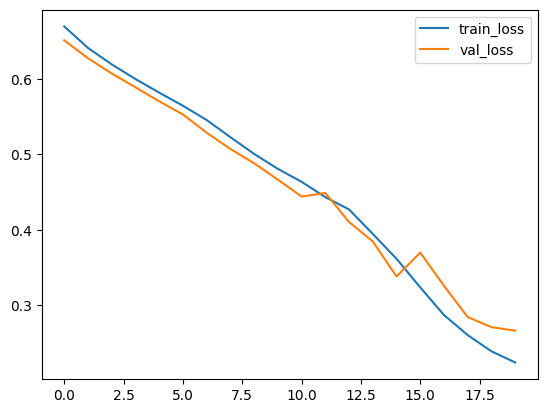

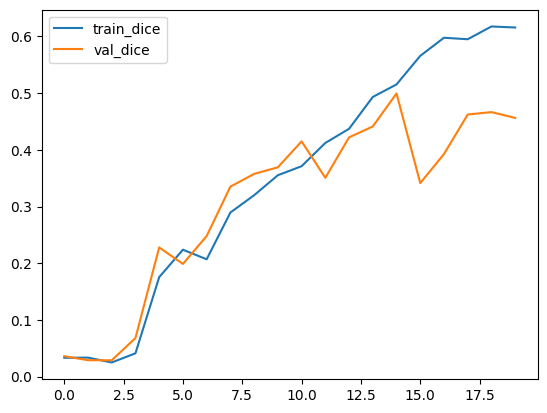

In [129]:
model = get_model()

n_params = sum(p.numel() for p in model.parameters())
print(f"Model has {n_params} parameters.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # device to run calculations - "cuda" means gpu
print(f"Using device {device}")
model.to(device) # convert model to the correct device
loss_fn = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

history = run_training_with_dice(model, optimizer, loss_fn, new_train_loader, val_dataloader=val_loader, max_epochs=20)

key = 'loss'
for name, metrics in history.items():
    if key not in name:
        continue
    plt.plot(metrics, label=name)
plt.legend()

plt.figure()
key = 'dice'
for name, metrics in history.items():
    if key not in name:
        continue
    plt.plot(metrics, label=name)
plt.legend()


Step 3. Mitigating overfitting

You are now free to experiment with modifying any part of the training pipeline. The goal is to reduce overfitting and improve the best validation dice. Suggestions and hints are outlined below.

In [154]:
# Suggestion 1 - Modifying the model architecture.


# read the monai documentation about UNet and edit the model configuration and experiment with the results.
# feel free to copy the documentation into a language model for advice on which configuration changes could mitigate overfitting!
def get_model():
    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128),
        strides=(2, 2, 2),
        num_res_units=2,
        dropout=0.2 # <---------- Added dropout
    )
    return model

In [131]:
# Suggestion 2 - Modifying the optimizer.

# read the documentation about torch.optim.AdamW with the help of a language model. See if configuration changes could mitigate overfitting to improve performance

def get_optimizer():

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.1) # <---- Added weight decay!
    return optimizer

In [148]:
# Suggestion 3 - Modifying the data pipeline


# Data augmentation is a common technique to reduce overfitting by creating more variations in the data being used to train the model.
# Read the monai documentation for transforms such as https://docs.monai.io/en/1.3.0/transforms.html#randadjustcontrastd and https://docs.monai.io/en/1.3.0/transforms.html#randcoarseshuffled
# to see if adding these into the data pipeline can improve outcomes.
# ! WARNING ! be sure to disable them when you are creating the transform for the validation set by setting `is_train=False`

def make_transform(n_pixels=64, is_train=True):
    # Steps to transform the file information to model inputs:

    transforms = []

    # step 1: load the data, nii.gz format to tensor
    transforms.append(
        T.LoadImaged(keys=['image', 'label'])
    )

    # step 2: Add an extra "channel" dimension (pytorch/monai convention)
    transforms.append(
        T.EnsureChannelFirstd(keys=['image', 'label'])
    )

    # step 3: Resize the data to a uniform size
    transforms.append(
        T.ResizeD(keys=['image', 'label'], spatial_size=(n_pixels, n_pixels, n_pixels//2), mode=['bilinear', 'nearest'])
    )

    # step 4: rescale the image intenisty between 0 and 1
    transforms.append(T.ScaleIntensityD(keys=['image']))

    if is_train:
        # Added data augmentations here <-----------------
        transforms.append(T.RandGaussianNoised(keys=['image'], prob=0.1))
        transforms.append(T.RandAdjustContrastd(keys=['image'], prob=1))
        transforms.append(T.RandScaleIntensityd(keys=['image'], prob=1, factors=(5, 10)))

    transform = T.Compose(transforms)
    return transform


In [149]:
new_train_ds = monai.data.CacheDataset(new_train_files, transform=make_transform(64), cache_rate=1)
new_train_loader = torch.utils.data.DataLoader(new_train_ds, batch_size=4, shuffle=True)

val_ds = monai.data.CacheDataset(val_files, transform=make_transform(64, is_train=False), cache_rate=1)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=4, shuffle=True)



Loading dataset: 100%|██████████| 11/11 [00:05<00:00,  2.06it/s]


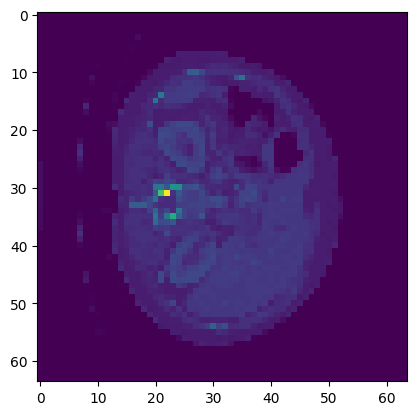

In [151]:
plt.imshow(new_train_ds[0]['image'][0, :, :, 16])

Model has 1186765 parameters.
Using device cpu


Epoch 0:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1, avg loss: 0.6495


Epoch 2, avg loss: 0.6154


Epoch 3, avg loss: 0.5976


Epoch 4, avg loss: 0.5827


Epoch 5, avg loss: 0.5701


Epoch 6, avg loss: 0.5595


Epoch 7, avg loss: 0.5475


Epoch 8, avg loss: 0.5348


Epoch 9, avg loss: 0.5232


Epoch 10, avg loss: 0.5143


Epoch 11, avg loss: 0.5058


Epoch 12, avg loss: 0.4979


Epoch 13, avg loss: 0.4869


Epoch 14, avg loss: 0.4806


Epoch 15, avg loss: 0.4717


Epoch 16, avg loss: 0.4630


Epoch 17, avg loss: 0.4535


Epoch 18, avg loss: 0.4392


Epoch 19, avg loss: 0.4296


Epoch 20, avg loss: 0.4142


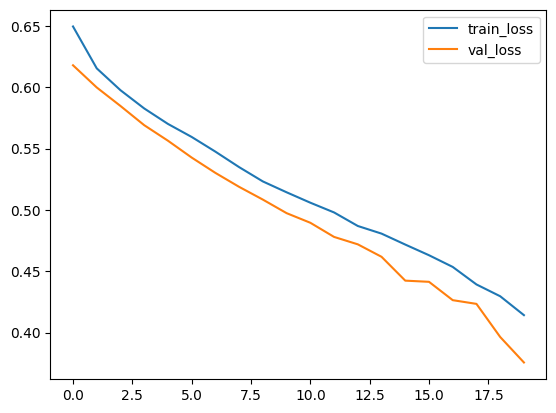

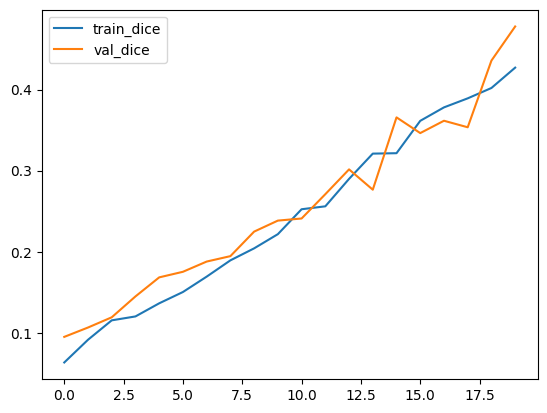

In [155]:
model = get_model()

n_params = sum(p.numel() for p in model.parameters())
print(f"Model has {n_params} parameters.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # device to run calculations - "cuda" means gpu
print(f"Using device {device}")
model.to(device) # convert model to the correct device
loss_fn = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.1)

history = run_training_with_dice(model, optimizer, loss_fn, new_train_loader, val_dataloader=val_loader, max_epochs=20)

key = 'loss'
for name, metrics in history.items():
    if key not in name:
        continue
    plt.plot(metrics, label=name)
plt.legend()

plt.figure()
key = 'dice'
for name, metrics in history.items():
    if key not in name:
        continue
    plt.plot(metrics, label=name)
plt.legend()